# A New Cafe in Manhattan

For this project we are going to help find the best area in Downtown Manhattan to open a new cafe.  As Manhattan is a pretty saturated market for cafes and is an expensive area to operate in, it is crucial for to gain a deeper understanding of the market we are entering. Using location data from currently successful restaurant operations, we can re cluster Manhattan based on the locations of these high volume restaurants rather than the neighborhoods they fall in, which may give us a different understanding of where people are going out to eat.  
Our goal is to use data and clustering to find a high volume area that is the least saturated with cafes and coffee shops on our list. By positioning the new cafe near other high volume locations, we may be able to capitalize on existing traffic trends. 

To help answer this problem, we will be using a dataset scraped from  [Restaurant Business Online's future 50 restaurants.](https://www.restaurantbusinessonline.com/future-50-2020) and made available via Michal Bogacz on [kaggle](https://www.kaggle.com/michau96/restaurant-business-rankings-2020).  This list includes fifty restaurants that were able to successfully grow their operations during a difficult period in the industry, and were chosen for their ability to adapt and likeliness to continue to excel in the future. The data frame includes the following columns:

Rank = Position in ranking  
Restaurant = Name of restaurant  
Location = Location of origin of the restaurant  
Sales = 2019 Systemwide Sales   	
YOY Sales = Year on year sales increase  	
Stores = Number of premises  	
'YOY Store Growth' = Year on year premises increase 	
Unit_Volume = 2019 Average Unit Volume ($000)   	
Franchising = Is the restaurant a franchise? (Y/N) 
<a id='cleaning'></a>

We will focus on the New York Based companies on this list and group their New York City locations based on coordinates.  We will then cluster these groups and find the average volumes of each zone.  We will see what type of stores appear in which zone, and find which zones could potentially be considered for future cafe locations.  

**Table of Contents**  
1.) [Data Cleaning](#cleaning)    
 2.) [EDA](#EDA)  
 3.) [Clustering](#clustering)  
 4.) [Results](#results) 
 

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import requests
from pandas.io.json import json_normalize


import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

from sklearn.cluster import KMeans

! pip install folium==0.5.0
import folium
print('Folium Installed!')

     |████████████████████████████████| 79 kB 9.9 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=1d5efbe23e2e333603f150f51d583c546e92302ffe3a4b995b387383c96a2aa8
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Folium Installed!


In [3]:
df = pd.read_csv(body)
df.head()

,Rank,Restaurant,Location,Sales,YOY_Sales,Units,YOY_Units,Unit_Volume,Franchising
0,1,Evergreens,"Seattle, Wash.",24,130.5%,26,116.7%,1150,No
1,2,Clean Juice,"Charlotte, N.C.",44,121.9%,105,94.4%,560,Yes
2,3,Slapfish,"Huntington Beach, Calif.",21,81.0%,21,90.9%,1370,Yes
3,4,Clean Eatz,"Wilmington, N.C.",25,79.7%,46,58.6%,685,Yes
4,5,Pokeworks,"Irvine, Calif.",49,77.1%,50,56.3%,1210,Yes


In [4]:
df.shape

(50, 9)

In [5]:
df.dtypes

Rank            int64
Restaurant     object
Location       object
Sales           int64
YOY_Sales      object
Units           int64
YOY_Units      object
Unit_Volume     int64
Franchising    object
dtype: object

In [6]:
#changing percents to floats

df['YOY_Sales']=df['YOY_Sales'].apply(lambda x:x.replace('%',''))
df['YOY_Units']=df['YOY_Units'].apply(lambda x:x.replace('%',''))
#===
df['YOY_Sales']= pd.to_numeric(df['YOY_Sales'])
df['YOY_Units']=pd.to_numeric(df['YOY_Units'])

In [7]:
df = df.rename(columns={'Units' : 'Stores','YOY_Units' : 'YOY_Store_Growth'})


# EDA

Let's get an idea for how many locations the restaurants on this list have: 
<a id='EDA'></a>

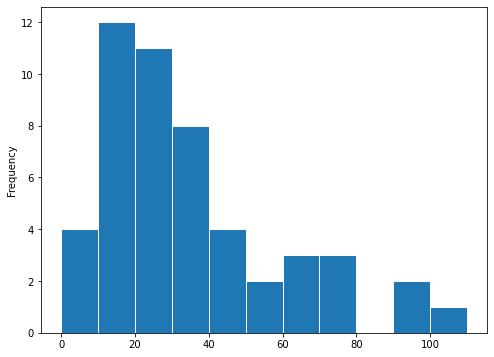

In [8]:
plt.figure(figsize=(8,6))
bins=[0,10,20,30,40,50,60,70,80,90,100,110]
df['Stores'].plot(kind='hist',bins=bins,edgecolor='w')

We can also take a closer look at what cities these stores are based in:

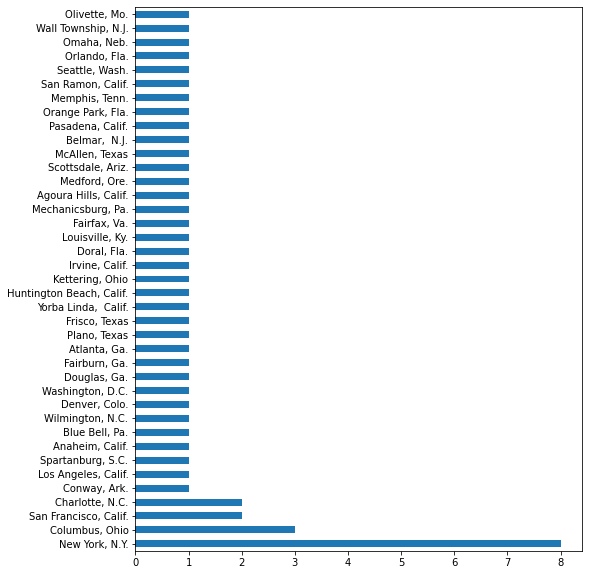

In [9]:
plt.figure(figsize=(8,10))
df['Location'].value_counts().plot(kind='barh')

Let's also take a look at how many of these stores on the list are franchises:

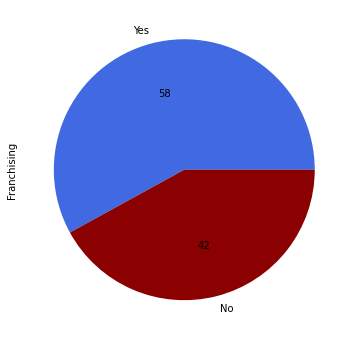

In [10]:
plt.figure(figsize=(6,6))

df['Franchising'].value_counts().plot(kind='pie',autopct='%.f',colors = ['royalblue','darkred'])
plt.show()

we can check and see if franchising has any correlation with the other numbers in our dataframe.

In [11]:
franchise_onehot = pd.get_dummies(df[['Franchising']], prefix="", prefix_sep="")
franchise_onehot = franchise_onehot.rename(columns={'Yes' : 'Franchise?'})
df['Franchise?'] = franchise_onehot['Franchise?']

we'll do the same with NYC locations and see if there is any correlation there as well.  

In [12]:
location_onehot = pd.get_dummies(df[['Location']], prefix="", prefix_sep="")
df['NYC'] = location_onehot['New York, N.Y.']


In [13]:
dfcorr = df[['Sales','YOY_Sales','YOY_Store_Growth','Unit_Volume','Franchise?','NYC','Stores']]

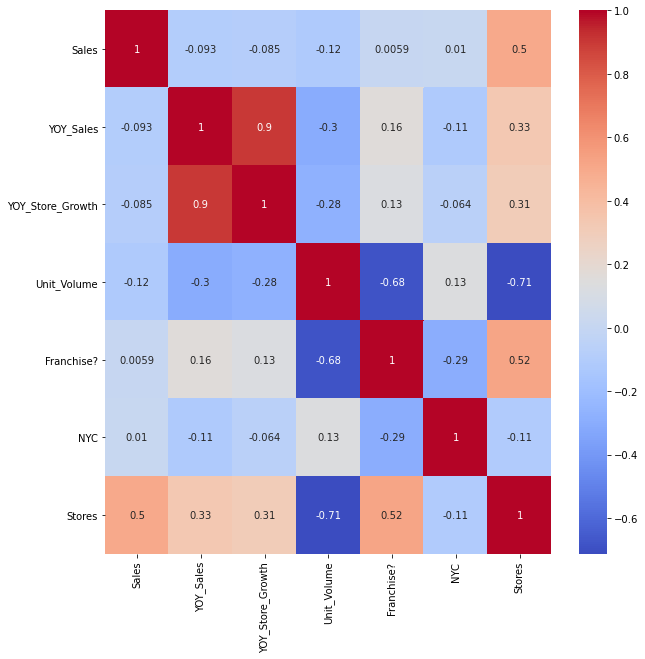

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(dfcorr.corr(), annot=True,cmap='coolwarm')

Nothing too surprising here. From this heatmap, you could say that franchises tend to have slightly more locations and do overall less volume per location.  It is pretty apparent that the more stores you have, the less volume you tend to do at your locations.  We're going to explore volume a but further, and focus our efforts around New York City, where we are planning to open our cafe.   

In [15]:
dfny = df[df.Location=="New York, N.Y."]
dfny = dfny.sort_values('Unit_Volume',ascending=False,ignore_index=True)
dfny

,Rank,Restaurant,Location,Sales,YOY_Sales,Stores,YOY_Store_Growth,Unit_Volume,Franchising,Franchise?,NYC
0,34,Boqueria,"New York, N.Y.",27,22.0,7,16.7,4260,No,0,1
1,25,By Chloe,"New York, N.Y.",37,25.6,14,7.7,2800,No,0,1
2,23,The Little Beet,"New York, N.Y.",23,26.5,12,33.3,2230,No,0,1
3,29,Dos Toros Taqueria,"New York, N.Y.",28,24.0,22,10.0,1375,No,0,1
4,8,Melt Shop,"New York, N.Y.",20,39.6,19,35.7,1260,Yes,1,1
5,32,Just Salad,"New York, N.Y.",42,22.7,38,26.7,1240,No,0,1
6,14,Bluestone Lane,"New York, N.Y.",48,33.0,48,37.1,1175,No,0,1
7,24,Joe & The Juice,"New York, N.Y.",47,25.9,69,25.5,760,Yes,1,1


In [16]:
#drop columns we won't be using
dfny = dfny[['Restaurant','Sales','YOY_Sales','Stores','YOY_Store_Growth','Unit_Volume','Franchise?']]

In [17]:
dfny =dfny.rename(columns={'Restaurant' : 'name'})

Let's incorporate the Foursquare location data and get a feel for where these places are located in New York City.  

In [19]:
#Since we have no specified locations yet, we'll plug in the coordinates for New York City, and find locations from there.
NYC_lat = 40.7128
NYC_lng = -74.0060

We'll start by looking at the two shops on our list with the most overall stores, Joe & the Juice and Bluestone Lane, they coincidentally have the lowest volume per location, but this could also be indicative of the products they are selling and not just store location.

In [20]:
#function from the IBM Coursera Training labs that extracts venue category from JSON file

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
search_query = 'Joe & The Juice'
LIMIT = 70 #There are 69 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Joe & The Juice&radius=10000&limit=70'

In [22]:
results = requests.get(url).json()

In [23]:
venues = results['response']['venues']
    
joes = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
joes =joes.loc[:, filtered_columns]

# filter the category for each row
joes['Type'] = joes.apply(get_category_type, axis=1)

# clean columns
joes.columns = [col.split(".")[-1] for col in joes.columns]

joes.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.715674,-74.010960,Juice Bar
1,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.722482,-73.997453,Juice Bar
2,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.712777,-74.013345,Juice Bar
3,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.705570,-74.008160,Juice Bar
4,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.705941,-74.011644,Juice Bar


In [24]:
joes.shape

(50, 5)

Our search turned up 50 matching items within 10000 Meters of New York City.  
Let's see how many are Joe & the Juice Locations.

In [25]:
joes['name'].value_counts()

JOE & THE JUICE                                                       13
Joe Coffee Company                                                     6
Trader Joe's                                                           4
Joe Coffee                                                             3
Law Office of Joe Stancati                                             2
Joe & John's Pizza                                                     1
Joe and Sal's Pizza                                                    1
Tokyo Joe                                                              1
Joe Hug Deli                                                           1
Joe                                                                    1
Joe Pro Shop                                                           1
Joe’s Pizza                                                            1
Joe Coffee (in Arlo Hudson Square)                                     1
Joe: The Art of Coffee                             

We got 13 true matches.  We'll drop the other stores on our list and focus only on the Joe & the Juice locations.

In [26]:
JustJoes = joes[joes['name'].str.contains("JOE & THE JUICE")]
JustJoes = JustJoes[['name','lat','lng','Type']]
JustJoes

,name,lat,lng,Type
0,JOE & THE JUICE,40.715674,-74.010960,Juice Bar
1,JOE & THE JUICE,40.722482,-73.997453,Juice Bar
2,JOE & THE JUICE,40.712777,-74.013345,Juice Bar
3,JOE & THE JUICE,40.705570,-74.008160,Juice Bar
4,JOE & THE JUICE,40.705941,-74.011644,Juice Bar
6,JOE & THE JUICE,40.725983,-74.001298,Juice Bar
16,JOE & THE JUICE,40.762738,-73.977966,Juice Bar
21,JOE & THE JUICE,40.765877,-73.981975,Juice Bar
26,JOE & THE JUICE,40.754717,-73.982774,Juice Bar
34,JOE & THE JUICE,40.770128,-73.962422,Juice Bar


I'll rename the stores so they match our other dataframe.

In [27]:
JustJoes['name'] = JustJoes['name'].str.replace('JOE & THE JUICE','Joe & The Juice')


Now let's do the same for Bluestone Lane.

In [28]:
search_query = 'Bluestone Lane'
LIMIT = 50 #There are 48 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url2

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Bluestone Lane&radius=10000&limit=50'

In [29]:
results2 = requests.get(url2).json()

In [30]:
venues2 = results2['response']['venues']
    
bluestone = json_normalize(venues2) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
bluestone =bluestone.loc[:, filtered_columns]

# filter the category for each row
bluestone['Type'] = bluestone.apply(get_category_type, axis=1)

# clean columns
bluestone.columns = [col.split(".")[-1] for col in bluestone.columns]

bluestone.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.706268,-74.011687,Café
1,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.700880,-73.988060,Café
2,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.730009,-74.002855,Café
3,Bluestone Lane,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",40.730104,-73.990307,Coffee Shop
4,Bluestone Lane Collective Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.735808,-74.000863,Café


In [31]:
bluestone.shape

(50, 5)

In [32]:
bluestone['name'].value_counts()

Bluestone Lane                      20
Maiden Lane Medical                  2
Brick Lane Curry House               1
Park Lane Deli                       1
Bluestone Lane Collective Cafe       1
Plaza at 59 Maiden Lane              1
59 Maiden Lane                       1
Andrew Lavoott Bluestone             1
Lane Cafe                            1
Lane Jewelers                        1
100 Maiden Lane Sundeck              1
33 Maiden Lane                       1
Maiden Lane (History)                1
Butter Lane                          1
Bluestone                            1
Bluestone Lane Coffee                1
Cherry Lane Theatre                  1
Bluestone Café                       1
Dutch Lane Walk of Shame             1
Maiden Lane Plumbing and Heating     1
180 Maiden Lane                      1
80 Maiden Lane                       1
Xpress Lane Pharmacy                 1
Brouwerij Lane                       1
Minetta Lane Theatre                 1
100 Maiden Lane GYM      

In [33]:
bluestone = bluestone[bluestone['name'].str.contains("Bluestone Lane")]
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Coffee','Bluestone Lane')
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Collective Cafe','Bluestone Lane')
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Cafe ','Bluestone Lane')


In [34]:
bluestone = bluestone[['name','lat','lng','Type']]

Let's view how these cafes are spread out across manhattan.

In [35]:
cafe_map = folium.Map(location=[NYC_lat, NYC_lng], zoom_start=12)

for lat, lng, label in zip(bluestone.lat, bluestone.lng, bluestone.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='grey',
        popup=label,
        fill = True,
        fill_color='dodgerblue',
        fill_opacity=0.6
    ).add_to(cafe_map)
    

for lat, lng, label in zip(JustJoes.lat, JustJoes.lng, JustJoes.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        popup=label,
        fill = True,
        fill_color='deeppink',
        fill_opacity=0.6
    ).add_to(cafe_map)
    
    
cafe_map

Next, let's get info for the rest of the list.

In [36]:
search_query = 'Boqueria'
LIMIT = 10 #There are 7 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url3 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url3

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Boqueria&radius=10000&limit=10'

In [37]:
results3 = requests.get(url3).json()

In [38]:
venues3 = results3['response']['venues']
    
boqueria = json_normalize(venues3) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
boqueria =boqueria.loc[:, filtered_columns]

# filter the category for each row
boqueria['Type'] = boqueria.apply(get_category_type, axis=1)

# clean columns
boqueria.columns = [col.split(".")[-1] for col in boqueria.columns]

boqueria.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.724800,-74.002220,Tapas Restaurant
1,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.740200,-73.993770,Tapas Restaurant
2,Boqueria,"[{'id': '4bf58dd8d48988d150941735', 'name': 'S...",40.771510,-73.956073,Spanish Restaurant
3,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.755582,-73.990337,Tapas Restaurant


In [39]:
boqueria.shape

(4, 5)

In [40]:
boqueria = boqueria[['name','lat','lng','Type']]

In [41]:
search_query = 'By Chloe'
LIMIT = 20 #There are 14 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url4 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url4

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=By Chloe&radius=10000&limit=20'

In [42]:
results4 = requests.get(url4).json()

In [43]:
venues4 = results4['response']['venues']
    
chloe = json_normalize(venues4) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
chloe =chloe.loc[:, filtered_columns]

# filter the category for each row
chloe['Type'] = chloe.apply(get_category_type, axis=1)

# clean columns
chloe.columns = [col.split(".")[-1] for col in chloe.columns]

chloe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,By Chloe.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.706532,-74.004134,Vegetarian / Vegan Restaurant
1,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.722770,-73.997200,Vegetarian / Vegan Restaurant
2,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.715214,-73.959363,Vegetarian / Vegan Restaurant
3,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.736640,-73.991220,Vegetarian / Vegan Restaurant
4,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.758063,-73.978854,Vegetarian / Vegan Restaurant


In [44]:
chloe = chloe[['name','lat','lng','Type']]
chloe.name.value_counts()

by CHLOE.                                        5
By Chloe.                                        2
DoubleTree by Hilton                             1
Courtyard by Marriott New York Manhattan/SoHo    1
by. CHLOE                                        1
New York by Gehry Game Room                      1
CUT by Wolfgang Puck                             1
Thrills By CHLOE.                                1
Courtyard by Marriott                            1
New York by Gehry                                1
Sweets by CHLOE.                                 1
New York By Gehry Pool                           1
Chefs Club by Food & Wine NY                     1
Chloe 81                                         1
Green Apple Cleaners @ New York by Gehry         1
Name: name, dtype: int64

In [45]:
chloe['name'] = chloe['name'].str.replace('Sweets by CHLOE.','By Chloe')
chloe['name'] = chloe['name'].str.replace('by CHLOE.','By Chloe')
chloe['name'] = chloe['name'].str.replace('By Chloe.','By Chloe')
chloe['name'] = chloe['name'].str.replace('by. CHLOE','By Chloe')

chloe = chloe[chloe['name'].str.contains("By Chloe")]
chloe

,name,lat,lng,Type
0,By Chloe,40.706532,-74.004134,Vegetarian / Vegan Restaurant
1,By Chloe,40.722770,-73.997200,Vegetarian / Vegan Restaurant
2,By Chloe,40.715214,-73.959363,Vegetarian / Vegan Restaurant
3,By Chloe,40.736640,-73.991220,Vegetarian / Vegan Restaurant
4,By Chloe,40.758063,-73.978854,Vegetarian / Vegan Restaurant
5,By Chloe,40.741862,-73.992998,Vegetarian / Vegan Restaurant
6,By Chloe,40.753019,-73.987703,Vegetarian / Vegan Restaurant
8,By Chloe,40.729262,-74.000920,Bakery
9,By Chloe,40.759154,-73.971021,Vegetarian / Vegan Restaurant


In [46]:
search_query = 'The Little Beet'
LIMIT = 15  #There are 12 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url5 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url5

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=The Little Beet&radius=10000&limit=15'

In [47]:
results5 = requests.get(url5).json()

In [48]:
venues5 = results5['response']['venues']
    
beet = json_normalize(venues5) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
beet =beet.loc[:, filtered_columns]

# filter the category for each row
beet['Type'] = beet.apply(get_category_type, axis=1)

# clean columns
beet.columns = [col.split(".")[-1] for col in beet.columns]

beet.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,The Little Beet Table,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.741086,-73.985333,Restaurant
1,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.726851,-74.037911,Restaurant
2,The Little Beet,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.744036,-73.988810,Vegetarian / Vegan Restaurant
3,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.760870,-73.982480,Restaurant
4,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.757786,-73.974309,Restaurant


In [49]:
beet = beet[['name','lat','lng','Type']]
beet.name.value_counts()

The Little Beet                       7
The Little One NYC                    1
The Little Gym of Tribeca             1
The Little Owl                        1
The Little Beet Table                 1
The Little Black Jacket Exhibition    1
The Little Shop                       1
The Little Sandwich Shop              1
The Little Place                      1
Name: name, dtype: int64

In [50]:
beet = beet[beet['name'].str.contains("The Little Beet")]
beet['name'] = beet['name'].str.replace('The Little Beet Table','The Little Beet')
beet

,name,lat,lng,Type
0,The Little Beet,40.741086,-73.985333,Restaurant
1,The Little Beet,40.726851,-74.037911,Restaurant
2,The Little Beet,40.744036,-73.988810,Vegetarian / Vegan Restaurant
3,The Little Beet,40.760870,-73.982480,Restaurant
4,The Little Beet,40.757786,-73.974309,Restaurant
5,The Little Beet,40.751498,-73.977821,Vegetarian / Vegan Restaurant
6,The Little Beet,40.705075,-74.009160,Restaurant
8,The Little Beet,40.753955,-73.985541,Restaurant


In [51]:
search_query = 'Dos Toros Taqueria'
LIMIT = 25  #There are 22 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url6 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url6


'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Dos Toros Taqueria&radius=10000&limit=25'

In [52]:
results6 = requests.get(url6).json()

In [53]:
venues6 = results6['response']['venues']
    
toros = json_normalize(venues6) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
toros =toros.loc[:, filtered_columns]

# filter the category for each row
toros['Type'] = toros.apply(get_category_type, axis=1)

# clean columns
toros.columns = [col.split(".")[-1] for col in toros.columns]

toros.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,Dos Toros Taquería,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",40.713058,-74.015980,Burrito Place
1,Dos Toros Taqueria,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",40.706892,-74.006850,Burrito Place
2,Dos Toros Taqueria,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",40.730347,-74.002196,Burrito Place
3,Dos Toros Taquería,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",40.733699,-73.989639,Mexican Restaurant
4,Dos Toros Taqueria,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",40.741482,-73.993792,Burrito Place


In [54]:
toros = toros[['name','lat','lng','Type']]
toros.name.value_counts()

Dos Toros Taqueria    11
Dos Toros Taquería     5
Dos Toros              2
Dos Toros HQ           1
Name: name, dtype: int64

In [56]:
search_query = 'Melt Shop'
LIMIT = 20  #There are 19 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url7 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url7


'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Melt Shop&radius=10000&limit=20'

In [57]:
results7 = requests.get(url7).json()

In [58]:
venues7 = results7['response']['venues']
    
melt = json_normalize(venues7) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
melt =melt.loc[:, filtered_columns]

# filter the category for each row
melt['Type'] = melt.apply(get_category_type, axis=1)

# clean columns
melt.columns = [col.split(".")[-1] for col in melt.columns]

melt.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,Melt Shop,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.709895,-74.006564,Sandwich Place
1,Melt Shop,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.726925,-74.038352,Restaurant
2,Melt Shop,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.744678,-73.990847,Sandwich Place
3,Melt Shop,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.763896,-73.985298,Sandwich Place
4,Melt Shop,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.760954,-73.982130,Sandwich Place


In [59]:
melt = melt[['name','lat','lng','Type']]
melt.name.value_counts()

Melt Shop                                   5
Kam Hing Coffee Shop 金興                     1
Hong Kong Barber Shop                       1
Lux Accessories @ Shop Small Pop-Up Mall    1
Mary's Coffee Shop                          1
The Men's Shop, Club Monaco                 1
Smoke Shop                                  1
The Magic Costume Shop                      1
Trader Joe's Wine Shop                      1
Dante Coffee Shop                           1
Alex Barber Shop                            1
J.Crew Men's Shop                           1
Ray's Barber Shop                           1
Royal Barber Shop                           1
Iron Valley Harley Davidson Shop            1
Melt Bakery                                 1
Name: name, dtype: int64

In [60]:
melt = melt[melt['name'].str.contains("Melt Shop")]

In [61]:
search_query = 'Just Salad'
LIMIT = 40  #There are 38 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url8 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url8

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Just Salad&radius=10000&limit=40'

In [62]:
results8 = requests.get(url8).json()

In [63]:
venues8 = results8['response']['venues']
    
salad = json_normalize(venues8) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
salad =salad.loc[:, filtered_columns]

# filter the category for each row
salad['Type'] = salad.apply(get_category_type, axis=1)

# clean columns
salad.columns = [col.split(".")[-1] for col in salad.columns]

salad.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.707042,-74.007174,Salad Place
1,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.703539,-74.011627,Salad Place
2,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.712219,-74.014414,Salad Place
3,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.712713,-74.008202,Salad Place
4,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.746318,-73.994003,Salad Place


In [64]:
salad = salad[['name','lat','lng','Type']]
salad.name.value_counts()

Just Salad                                  24
Joe's Salad Bar                              1
Just Scandinavian                            1
Pine Street Smoothies & Fruit Salad Cart     1
Just Cavalli Showroom                        1
Just Us League                               1
Just Train                                   1
Just Desserts                                1
Just Salad Goldman sachs cafeteria           1
Just Salad HQ                                1
Just Yogurt Truck                            1
Salad Box NY                                 1
Just Jenn Productions                        1
Just Shades                                  1
Just men                                     1
just phở                                     1
Just Bifocals                                1
Name: name, dtype: int64

In [65]:
salad = salad[salad['name'].str.contains("Just Salad")]
salad.name.value_counts()

Just Salad                            24
Just Salad Goldman sachs cafeteria     1
Just Salad HQ                          1
Name: name, dtype: int64

In [66]:
#concatenate our store dataframes
stores = pd.concat([beet, boqueria, chloe, bluestone, JustJoes, salad, melt, toros], axis=0)


## Clustering the stores into zones
<a id='clustering'></a>

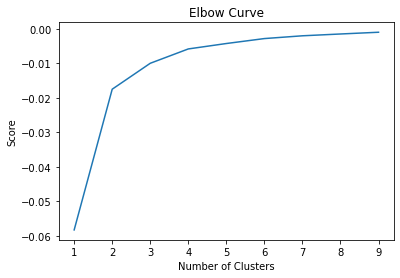

In [67]:
#elbow curve 
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = stores[['lat']]
X_axis = stores[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]


# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [68]:
kclusters = 4

In [69]:
kmeans = KMeans(n_clusters =kclusters, init ='k-means++')
kmeans.fit(stores[stores.columns[1:3]]) 
stores['cluster_label'] = kmeans.fit_predict(stores[stores.columns[1:3]])
centers = kmeans.cluster_centers_ 
labels = kmeans.predict(stores[stores.columns[1:3]])
stores.head(10)

,name,lat,lng,Type,cluster_label
0,The Little Beet,40.741086,-73.985333,Restaurant,3
1,The Little Beet,40.726851,-74.037911,Restaurant,0
2,The Little Beet,40.744036,-73.988810,Vegetarian / Vegan Restaurant,3
3,The Little Beet,40.760870,-73.982480,Restaurant,1
4,The Little Beet,40.757786,-73.974309,Restaurant,1
5,The Little Beet,40.751498,-73.977821,Vegetarian / Vegan Restaurant,1
6,The Little Beet,40.705075,-74.009160,Restaurant,0
8,The Little Beet,40.753955,-73.985541,Restaurant,1
0,Boqueria,40.724800,-74.002220,Tapas Restaurant,3
1,Boqueria,40.740200,-73.993770,Tapas Restaurant,3


Let's visualize the clusters on a map and see what types of stores make up each cluster.

In [97]:
cluster_map = folium.Map(location=[NYC_lat, NYC_lng], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stores['lat'], stores['lng'], stores['Type'], stores['cluster_label']):
    label = folium.Popup(str(poi) + '-' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map

Now we can further analyze these clusters and see if there are any similarities between the numbers and which type of stores populate which areas.



In [71]:
# merge sales data to our cluster dataframe
merged = pd.merge(
    stores,
    dfny,
    how="inner",
    on=None,
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [72]:
merged.head(10)

,name,lat,lng,Type,cluster_label,Sales,YOY_Sales,Stores,YOY_Store_Growth,Unit_Volume,Franchise?
0,Bluestone Lane,40.706268,-74.011687,Café,0,48,33.0,48,37.1,1175,0
1,Bluestone Lane,40.700880,-73.988060,Café,0,48,33.0,48,37.1,1175,0
2,Bluestone Lane,40.730009,-74.002855,Café,3,48,33.0,48,37.1,1175,0
3,Bluestone Lane,40.730104,-73.990307,Coffee Shop,3,48,33.0,48,37.1,1175,0
4,Bluestone Lane,40.735808,-74.000863,Café,3,48,33.0,48,37.1,1175,0
5,Bluestone Lane,40.704599,-74.008748,Café,0,48,33.0,48,37.1,1175,0
6,Bluestone Lane,40.713360,-74.034026,Café,0,48,33.0,48,37.1,1175,0
7,Bluestone Lane,40.783757,-73.958526,Café,2,48,33.0,48,37.1,1175,0
8,Bluestone Lane,40.721860,-73.995703,Café,3,48,33.0,48,37.1,1175,0
9,Bluestone Lane,40.755470,-73.983178,Coffee Shop,1,48,33.0,48,37.1,1175,0


# Results <a id='results'></a>

In [96]:
merged['cluster_label'].value_counts()

1    38
3    27
0    21
2    10
Name: cluster_label, dtype: int64

In [74]:
cluster_zero =  merged[merged['cluster_label']==0]
cluster_one =  merged[merged['cluster_label']==1]
cluster_two =  merged[merged['cluster_label']==2]
cluster_three =  merged[merged['cluster_label']==3]

# Cluster Zero

In [75]:
zero_mean = cluster_zero['Unit_Volume'].mean()
print('The average unit volume for zone 0 is :')
zero_mean

The average unit volume for zone 0 is :


1310.0

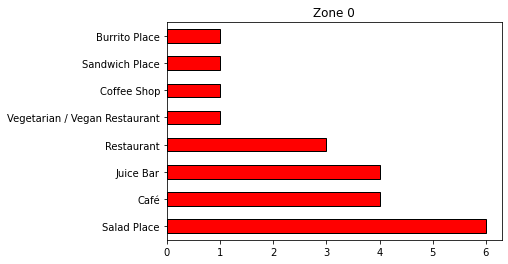

In [109]:
cluster_zero['Type'].value_counts().plot(kind='barh',color = 'red',edgecolor='black')
plt.title('Zone 0')
plt.show()

# Cluster One

In [84]:
one_mean = cluster_one['Unit_Volume'].mean()
print('The average unit volume for zone 1 is :')
one_mean

The average unit volume for zone 1 is :


1505.0

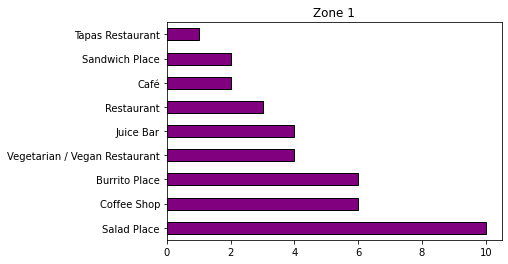

In [108]:
cluster_one['Type'].value_counts().plot(kind='barh',color = 'purple',edgecolor='black')
plt.title('Zone 1')
plt.show()

# Cluster Two

In [86]:
two_mean = cluster_two['Unit_Volume'].mean()
print('The average unit volume for zone 2 is :')
two_mean

The average unit volume for zone 2 is :


1460.0

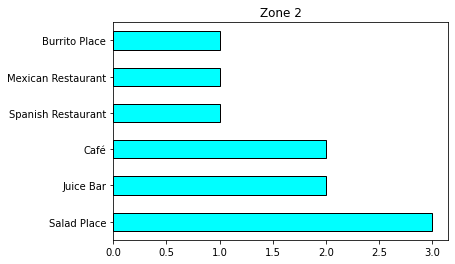

In [107]:
cluster_two['Type'].value_counts().plot(kind='barh',color = 'cyan',edgecolor='black')
plt.title('Zone 2')
plt.show()

# Cluster Three

In [93]:
three_mean = cluster_three['Unit_Volume'].mean()
print('The average unit volume for zone 3 is :')
three_mean

The average unit volume for zone 3 is :


1766.4814814814815

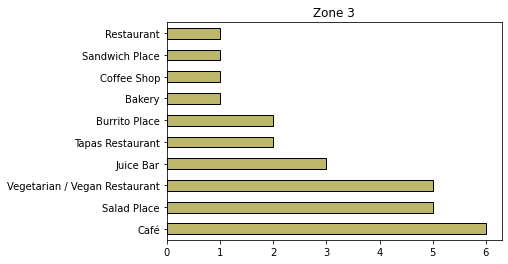

In [106]:
cluster_three['Type'].value_counts().plot(kind='barh',color = 'darkkhaki',edgecolor='black')
plt.title('Zone 3')
plt.show()

### Which zone is best for our new cafe?

From this data we would likely consider Zone 2, which has significant volume and less cafes and coffee shops when compared to the other zones.  We could also consider looking into zone 3, which has the highest average volume, however it holds the second most cafe and coffee shops.   